In [324]:
# Supress unnecessary warning messages

from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [325]:
import pickle
import matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis
from collections import Counter
from copy import deepcopy
from fancyimpute import MICE
from datetime import datetime
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

%matplotlib inline

In [659]:
# This cell is just about making things look nice

# Make plots bigger by default.
# Has to occur after the %matplotlib inline in a different cell. Known issue
plt.rc('figure', figsize=(14.0, 8.0))
matplotlib.rcParams.update({'font.size': 22})

# Make numpy outputs easier to read
np.set_printoptions(precision=3, formatter={'float': '{: 8.3f}'.format})

In [662]:
with open('./data/raw/user_subset.pkl', 'rb') as picklefile:
    user = pickle.load(picklefile)
with open('./data/raw/session_subset.pkl', 'rb') as picklefile:
    session = pickle.load(picklefile)

In [328]:
def drop_rare_values(df, threshold):
    df_obj = df.select_dtypes(include=[object]).iloc[:,1:]
    for column in df_obj.columns:
        levels = df[column].value_counts()/df.shape[0]
        insig_index = np.sum([x > threshold for x in levels.tolist()])
        for i in range(insig_index, levels.shape[0]):
            value = levels.index.tolist()[i]
            df[column].replace(value, 'catchall', inplace=True)
    return df

In [663]:
user.country_destination.value_counts()

NDF      12405
US        6245
other     1079
FR         490
IT         312
ES         240
GB         210
CA         121
DE         104
NL          72
AU          50
PT          17
Name: country_destination, dtype: int64

Text(0.5,1,'First booking by country')

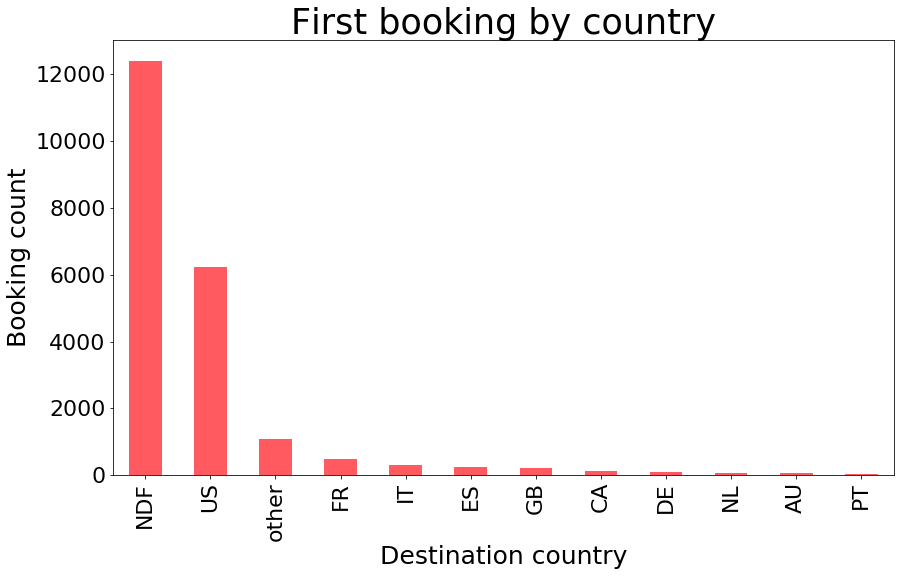

In [665]:
user.country_destination.value_counts().plot('bar', color = '#FF5A60')
plt.xlabel('Destination country', fontsize=25)
plt.ylabel('Booking count', fontsize=25)
plt.title('First booking by country', fontsize=35)

## Format and split user data

In [329]:
# Impute the missing action_type and action_details with mode values
def impute_mode(df, col_key, col_na, mode_table=None):
    
    if (mode_table is None):
        mode_series = df[~df[col_na].isnull()].groupby(col_key)[col_na].agg(lambda x:x.value_counts().index[0])
        mode_series = pd.DataFrame(mode_series.reset_index())
        mode_table = mode_series
    else:
        mode_series = mode_table
    merged_frame = pd.merge(df, mode_series, how='left', 
                             left_on=[col_key], 
                             right_on=[col_key]).set_index(df.index)
    
    merged_frame.rename(columns={col_na+'_x': col_na, col_na+'_y':'mode_value'}, inplace=True)
    merged_frame[col_na].fillna(merged_frame.mode_value, inplace=True)
    merged_frame.drop(['mode_value'], axis=1, inplace=True)
    
    return merged_frame, mode_table

In [330]:
def date_transformation(user):
    user['date_account_created'] = pd.to_datetime(user['date_account_created'], format='%Y-%m-%d')
    user['timestamp_first_active'] = pd.to_datetime(user['timestamp_first_active']//10000, format='%Y%m%d%H')
    user.drop('date_first_booking', axis=1, inplace=True)
    #user['account_age'] = user['date_account_created'].apply(lambda x:(x.year-1970)*12+x.month)
    user['create_year'] = user['date_account_created'].apply(lambda x:x.year)
    user['create_month'] = user['date_account_created'].apply(lambda x:x.month)
    
    #user['active_age'] = user['timestamp_first_active'].apply(lambda x:(x.year-1970)*12+x.month)
    user['active_year'] = user['timestamp_first_active'].apply(lambda x:x.year)
    user['active_month'] = user['timestamp_first_active'].apply(lambda x:x.month)
    user['active_hour'] = user['timestamp_first_active'].apply(lambda x:x.hour)
    
    user['signup_flow'] = user['signup_flow'].astype(int).astype('str')

    y_user = pd.DataFrame(user['country_destination'].values, columns=['country_destination'], index=user.id)
    X_user = user.drop(['country_destination'], axis=1)
    X_user.set_index('id', inplace=True)
    return X_user, y_user

## Deal with wrong and missing values in user data

In [331]:
def impute_age(X_user_train, age_mode=None):
    X_user_train.first_affiliate_tracked.fillna('catchall', inplace=True)
    X_user_train.loc[((X_user_train['age'] <= 18) | (X_user_train['age'] >= 100)), 'age' ] = np.NAN
    cols_to_drop = ['date_account_created', 'timestamp_first_active']
    X_user_train.drop(cols_to_drop, axis=1, inplace=True)

    # Imput data with median value
    # median_age = X_user_train[~X_user_train['age'].isna()].age.median()
    # X_user_train.loc[X_user_train['age'].isna(), 'age'] = median_age
    
    X_user_train, train_age_mode = impute_mode(X_user_train, 'first_device_type', 'age', age_mode)

    return X_user_train, train_age_mode

In [332]:
def custom_dummify(df, threshold, train_cols=None):
    df_concat = pd.DataFrame()
    df_noncat = df.select_dtypes(exclude=[object])
    # print(df_noncat.shape)
    df = df.select_dtypes(include=[object])
    
    all_cols = []
        
    for column in range(len(df.columns)):
        col_name = df.columns[column]
        levels = df.iloc[:,column].value_counts()
        count_all = np.sum(levels)
        significant_cols = []
        for level_values in sorted(list(levels.index)):
            if (levels[level_values]/count_all < threshold):
                pass
            else:
                significant_cols.append(level_values)
        df_dummy = pd.get_dummies(df[col_name], prefix=col_name)

        cols_to_keep = [(col_name+"_"+x) for x in significant_cols]
        if (train_cols != None):
            for x in cols_to_keep:
                if x not in train_cols:
                    cols_to_keep.remove(x)
        all_cols.extend(cols_to_keep)
        df_dummy_kept = pd.DataFrame(df_dummy[cols_to_keep], columns=cols_to_keep)
        df_dummy_agg = df_dummy.drop((cols_to_keep), axis=1)
        df_dummy_agg = pd.DataFrame(df_dummy_agg.sum(axis=1), columns=[col_name+'_catch_all'])
        df_unify = pd.concat([df_dummy_kept, df_dummy_agg], axis=1)
        df_concat = pd.concat([df_concat, df_unify], axis=1)
    # print(df_concat.shape)
    return pd.concat([df_noncat, df_concat], axis=1 ), all_cols

In [333]:
X_user, y_user = date_transformation(user)
user = drop_rare_values(user, 0.005)
X_user_train, X_user_test, y_user_train, y_user_test = train_test_split(X_user, y_user, test_size = 0.25, random_state=1234, stratify=y_user)
X_user_train, train_age_mode = impute_age(X_user_train)
X_user_train, user_train_cols = custom_dummify(X_user_train, 0.005)
X_user_train.drop('signup_flow_1', axis=1, inplace=True)

/anaconda3/envs/Python36/lib/python3.6/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/anaconda3/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/envs/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """

## Deal with wrong and missing values in session data


In [202]:
def impute_session(session_train):
    # Replace NaN in action column with others
    session_train['action'].fillna("catch-all", inplace=True)
    # Clip the sessions longer than 24 hours to 24 hours
    session_train.loc[session_train['secs_elapsed']>24*3600, 'secs_elapsed'] = 24*3600
    return session_train

In [203]:
def get_session_cat_stats(user_df, session_df):
    session_stats = pd.DataFrame(index=user_df.index)
    cat_cols = list(session_df.select_dtypes(include=[object]).columns)[1:]
    
    for col in cat_cols:
        val_freq = Counter(session_df[col])
        sig_val = sorted(list(val_freq.keys()))

        for val in sig_val:
            val_count = session_df.groupby(session_df.index).apply(lambda x, val=val, col=col: np.sum(x[col] == val))
            tmp = pd.DataFrame(val_count.values, columns=[col+'['+val+']'], index=val_count.index)
            session_stats = pd.merge(session_stats, tmp, how='left', left_index=True, right_index=True )
    return session_stats

In [204]:
session = drop_rare_values(session, 0.005)

session.set_index('user_id', drop=False, inplace=True)
train_index = list(X_user_train.index)
session_train = session[session['user_id'].isin(train_index)]
test_index = list(X_user_test.index)
session_test = session[session['user_id'].isin(test_index)]

session_train = impute_session(session_train)
session_test = impute_session(session_test)
session_train, action_type_mode = impute_mode(session_train, 'action', 'action_type')
session_train, action_detail_mode = impute_mode(session_train, 'action', 'action_detail')
session_train, action_secs_mode = impute_mode(session_train, 'action', 'secs_elapsed')
session_train.fillna("catch-all", inplace=True)
session_stats = get_session_cat_stats(X_user_train, session_train)

/anaconda3/envs/Python36/lib/python3.6/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/anaconda3/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [1221]:
with open('./data/processed/session_stats.pkl', 'wb') as picklefile:
    pickle.dump(session_stats, picklefile)

## Combine session and user data

In [334]:
def quantile_range(x):
    return x.quantile(0.75)-x.quantile(0.25)

In [335]:
def get_session_continous_stats(user_df, session_df):
    session_sec_stats = session_df.groupby('user_id')['secs_elapsed'].agg([np.median, np.mean, np.std, skew, kurtosis, quantile_range])
    session_sec_stats.rename(columns={'median':'sess[median]', 'mean':'sess[mean]', 'std':'sess[std]', 'skew':'sess[skew]', 'kurtosis':'sess[kurtosis]', 'quan_range':'sess[quan_range]'}, inplace=True)
    user_df = user_df.merge(session_sec_stats, how='left', left_index=True, right_index=True)
    return user_df

In [336]:
X_user_train_1 = deepcopy(X_user_train)
X_user_train_1 = X_user_train_1.merge(session_stats, how='left', left_index=True, right_index=True)
X_user_train_1 = get_session_continous_stats(X_user_train_1, session_train)
X_user_train_1.fillna(0.0, inplace=True)

/anaconda3/envs/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'user_id' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


## Build a baseline model for NDF and Booking

In [337]:
y_bin = deepcopy(y_user_train)
y_bin['booking'] = 1 - (y_bin['country_destination'] == 'NDF').astype('int')
y_bin.drop(['country_destination'], axis=1, inplace=True)
y_train=y_bin

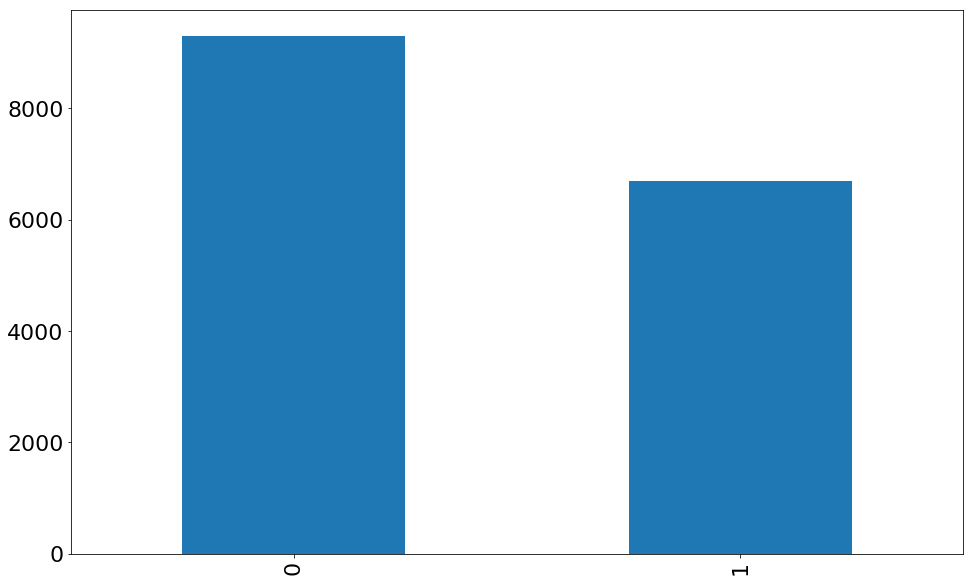

In [338]:
y_train['booking'].value_counts().plot('bar')

In [339]:
ssX = StandardScaler()
X_train_imputed_scaled = ssX.fit_transform(X_user_train_1)

In [259]:
models = [
          #('logistic', LogisticRegression),
          #('tree', DecisionTreeClassifier),
          #('forest', RandomForestClassifier),
          ('xgboost', XGBClassifier)
         ]

param_choices = [    


    {   'max_depth': [2,3,4],
        'n_estimators': [1, 125, 150, 175],
        'objective':['binary:logistic']
    }
]

y_train.values.reshape(-1,)
grids = {}
for model_info, params in zip(models, param_choices[:1]):
    name, model = model_info
    grid = RandomizedSearchCV(model(), params, scoring='accuracy', cv=4, n_jobs=-1)
    grid.fit(X_train_imputed_scaled, y_train.values.reshape(-1,))
    s = "{}: best score: {}".format(name, grid.best_score_)
    print(s)
    grids[name] = grid

/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

xgboost: best score: 0.7018365817091454


In [266]:
#print (grids['forest'].best_score_)
print (grids['xgboost'].best_score_)
print (grids['xgboost'].best_params_)

0.7018365817091454
{'objective': 'binary:logistic', 'n_estimators': 175, 'max_depth': 4}


0.7204522738630684
{'objective': 'binary:logistic', 'n_estimators': 175, 'max_depth': 3}

0.7203273363318341
{'objective': 'binary:logistic', 'n_estimators': 150, 'max_depth': 3}

xgboost: best score: 0.718015992003998
{'max_depth': 4, 'n_estimators': 100, 'objective': 'binary:logistic'}

logistic:
0.6760994502748626
{'penalty': 'l1', 'C': 0.2848035868435802}

**Result-Accuracy**<br>
knn: best score: 0.6414292853573214 <br>
logistic: best score: 0.6689780109945027 <br>
tree: best score: 0.698088455772114 <br>
forest: best score: 0.6454897551224388 <br>

**Result-AUC**<br>
knn: best score: 0.6797561404771426<br>
logistic: best score: 0.7137787331059189<br>
tree: best score: 0.7405620278725061<br>
forest: best score: 0.731510519720228<br>


**Result-AUC**<br>
knn: best score: 0.659525884390658<br>
logistic: best score: 0.7141040998794065<br>
tree: best score: 0.722326283870917<br>
forest: best score: 0.7526480939542807<br>
{'criterion': 'gini',<br>
 'min_samples_leaf': 3,<br>
 'min_samples_split': 7,<br>
 'n_estimators': 100}<br>
xgboost: best score: 0.7654377067200799<br>
{'learning_rate': 0.1778279410038923,<br>
 'max_depth': 5,<br>
 'n_estimators': 80,<br>
 'objective': 'binary:logistic'}<br>
 
 models = [('knn', KNN), 
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier),
          ('xgboost', XGBClassifier),
          ('svc', SVC )
         ]

param_choices = [
    {
        'n_neighbors': range(3, 9, 2)
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [1,3,5]
    },
    {
        'criterion':['gini','entropy'],
        'n_estimators': [10, 20, 50, 100],
        'min_samples_leaf':[1,3,5],
        'min_samples_split':[2,5,7]
    },
    {
        'max_depth': [3,5,7,9],
        'learning_rate': np.logspace(-3,0,5),
        'n_estimators': [10,50,80,100],
        'objective':['binary:logistic']
    },
    {
        'kernal': ['poly', 'rbf'],
        'degree': np.linspace(2, 8, 7), 
        'C': np.linspace(0.1, 10, 5)
    }
]

only values >1% <br>
logistic: best score: 0.6645427286356822<br>
tree: best score: 0.6787856071964018<br>
forest: best score: 0.6893428285857072<br>
xgboost: best score: 0.6954647676161919<br>
{'learning_rate': 0.03162277660168379, <br>
 'max_depth': 5, <br>
 'n_estimators': 100, <br>
 'objective': 'binary:logistic'} <br>

In [515]:
model1 = XGBClassifier(objective='binary:logistic', n_estimators=150, max_depth=3)
model1.fit(X_train_imputed_scaled, y_train.values.reshape(-1,))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [448]:
def plot_importance(model, df, title, columns=None):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-10:]
    plt.figure()
    plt.axvline(x=1/df.shape[1], color='#1DB954')
    plt.title(title, fontsize=35)
    plt.barh(range(10), importances[indices], color='#FF5A60', align='center', )
    if (columns == None):
        plt.yticks(range(10), df.columns[indices])
    else:
        plt.yticks(range(10), columns)
    plt.xlabel('Relative Importance', fontsize=25)
    return plt

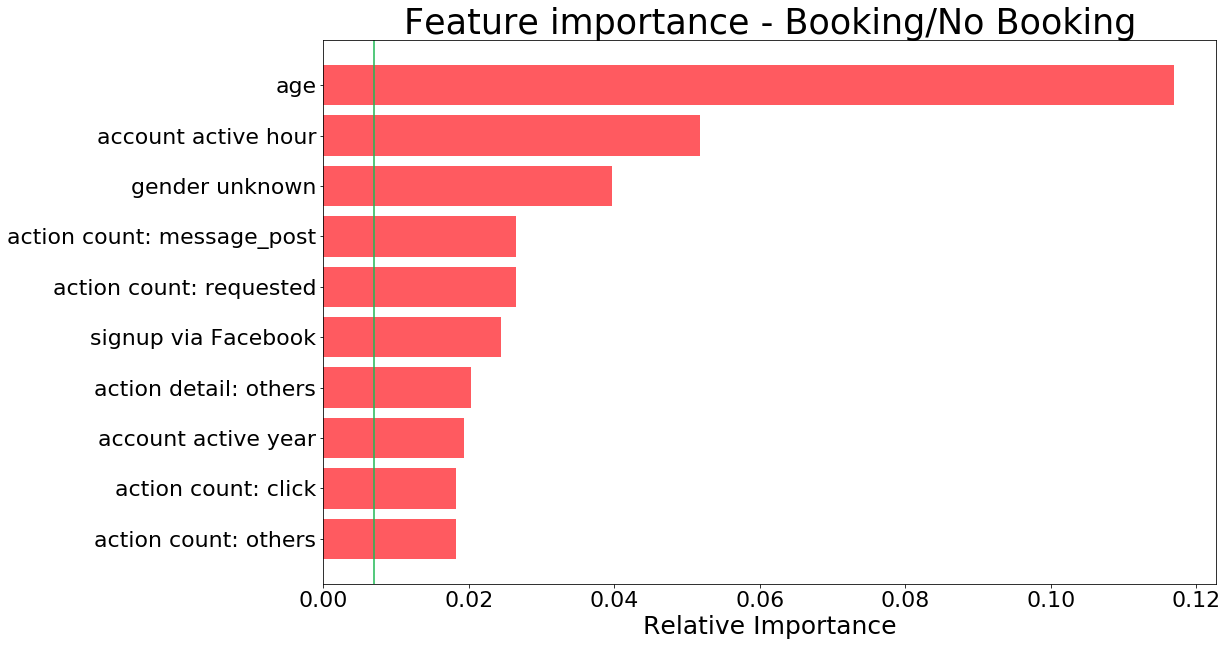

In [523]:
columns_name = (['age', 
            'account active hour', 
            'gender unknown',
            'action count: message_post',
            'action count: requested', 
            'signup via Facebook', 
            'action detail: others', 
            'account active year', 
            'action count: click', 
            'action count: others'])[::-1]
title = 'Feature importance - Booking/No Booking'
plot_importance(model1, X_user_train_1, title, columns_name);

In [55]:
# model1 = LogisticRegression(penalty='l1', C=0.284803586)
# model1.fit(X_train_imputed_scaled, y_train.values.reshape(-1,))

LogisticRegression(C=0.284803586, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [516]:
y_train_pred = model1.predict(X_train_imputed_scaled)
y_train_pred_soft = model1.predict_proba(X_train_imputed_scaled)
model1.score(X_train_imputed_scaled, y_train)

/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7366941529235382

In [457]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

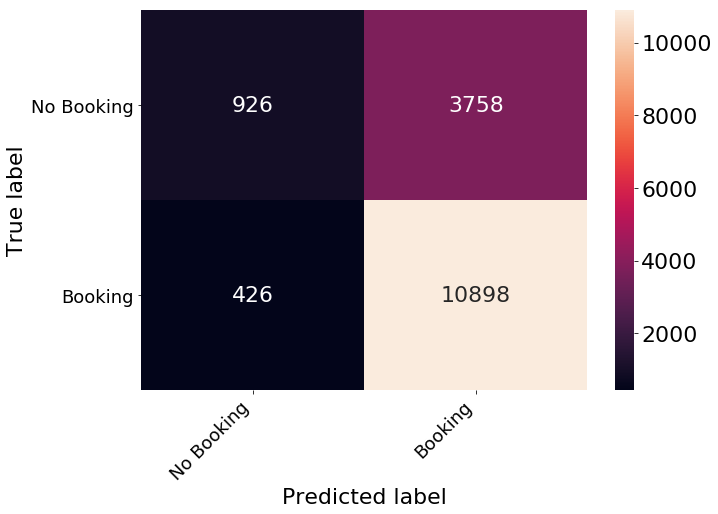

In [473]:
conf_mat = confusion_matrix(y_true=y_train, y_pred=y_train_pred)
cm = print_confusion_matrix(conf_mat, ['No Booking', 'Booking'])

## Build a model for US/Non-USA 

In [459]:
y_us = deepcopy(y_user_train)
y_us['booking'] = 1 - (y_us['country_destination'] == 'US').astype('int')
y_us.drop(['country_destination'], axis=1, inplace=True)
y_train=y_us

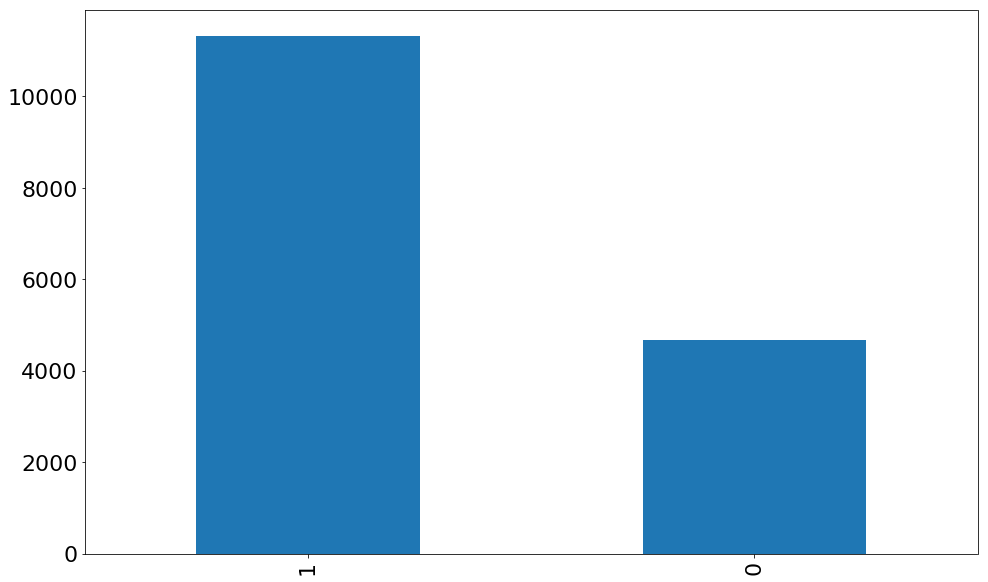

In [460]:
y_train['booking'].value_counts().plot('bar')

In [461]:
ssX2 = StandardScaler()
X_train_imputed_scaled2 = ssX2.fit_transform(X_user_train_1)

In [272]:
models = [
          #('logistic', LogisticRegression),
          #('tree', DecisionTreeClassifier),
          #('forest', RandomForestClassifier),
          ('xgboost', XGBClassifier)
         ]

param_choices = [    
    {
        'C': np.logspace(-3, 6, 6),
        'penalty': ['l1', 'l2']
    },
    """
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [1,3,5]
    },
    {
        'criterion':['gini','entropy'],
        'n_estimators': [40,50,60],
        'min_samples_leaf':[1,3],
        'min_samples_split':[2,5]
    },    
    """
    {
        'max_depth': [3,4,5],
        'n_estimators': [1, 50, 100,200],
        'objective':['binary:logistic']
    },
]


grids2 = {}
for model_info, params in zip(models, param_choices[:1]):
    name, model = model_info
    grid = GridSearchCV(model(), params, scoring='accuracy', cv=5, n_jobs=-1)
    grid.fit(X_train_imputed_scaled2, y_train.values.reshape(-1,))
    s = "{}: best score: {}".format(name, grid.best_score_)
    print(s)
    grids2[name] = grid

/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

xgboost: best score: 0.720952023988006


In [273]:
#print (grids['forest'].best_score_)
print (grids2['xgboost'].best_score_)
print (grids2['xgboost'].best_params_)

0.720952023988006
{'max_depth': 5, 'n_estimators': 100, 'objective': 'binary:logistic'}


0.7113318340829585
{'C': 0.06309573444801933, 'penalty': 'l1'}

0.7195777111444278
{'max_depth': 3, 'n_estimators': 200, 'objective': 'binary:logistic'}

In [465]:
model2 = XGBClassifier(objective='binary:logistic', n_estimators=100, max_depth=5)
model2.fit(X_train_imputed_scaled2, y_train.values.reshape(-1,))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [63]:
model2 = LogisticRegression(penalty='l1', C=0.0630957)
model2.fit(X_train_imputed_scaled2, y_train.values.reshape(-1,))

LogisticRegression(C=0.0630957, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

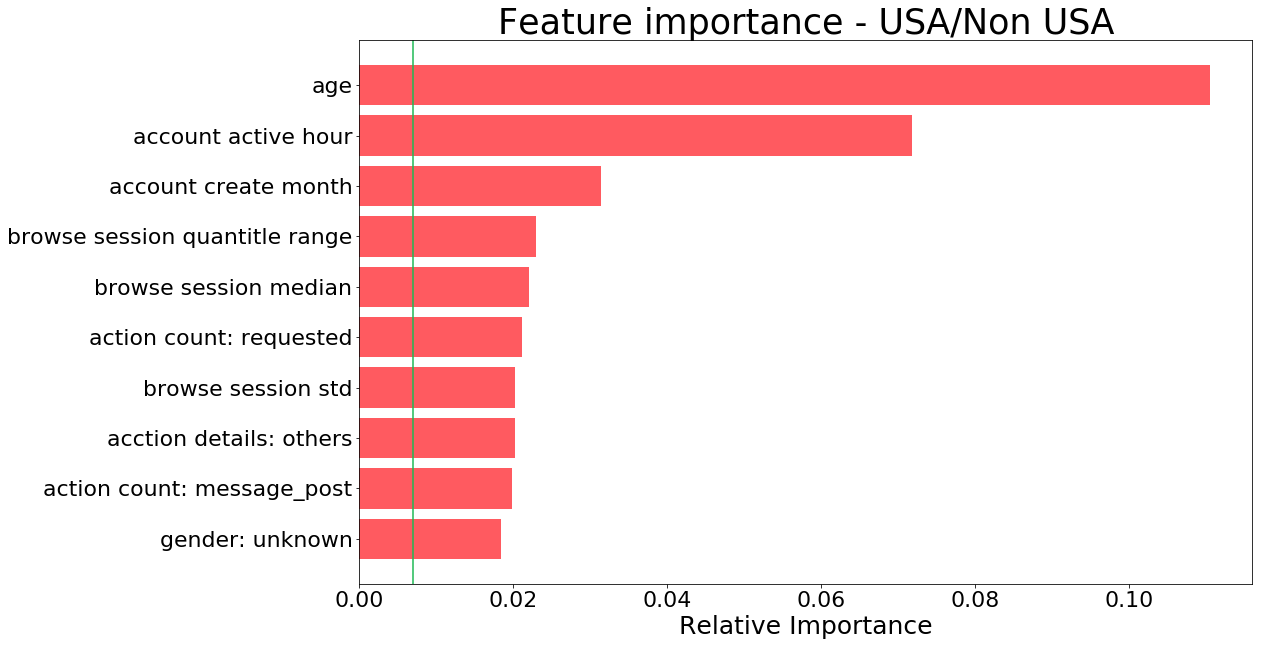

In [519]:
columns_name = (['age', 
            'account active hour', 
            'account create month', 
            'browse session quantitle range', 
            'browse session median', 
            'action count: requested', 
            'browse session std', 
            'acction details: others',
            'action count: message_post',
           'gender: unknown'])[::-1]
title = 'Feature importance - USA/Non USA'
plot_importance(model2, X_user_train_1, title, columns_name);

In [468]:
y_train_pred2 = model2.predict(X_train_imputed_scaled)
y_train_pred2_soft = model2.predict_proba(X_train_imputed_scaled)
model2.score(X_train_imputed_scaled, y_train)

/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7580584707646177

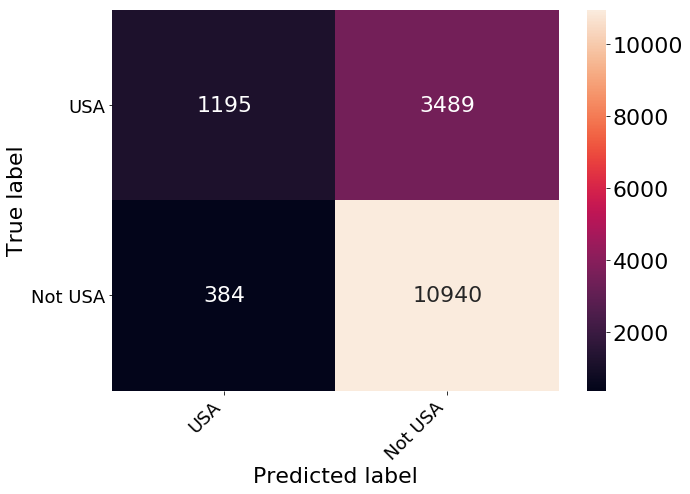

In [470]:
conf_mat = confusion_matrix(y_true=y_train, y_pred=y_train_pred2)
cm = print_confusion_matrix(conf_mat, ['USA', 'Not USA'])

## Oversampling and predicting

In [524]:
X_train_2nd = np.append(X_train_imputed_scaled, y_train_pred_soft[:,0].reshape(-1,1), axis=1)
X_train_2nd = np.append(X_train_2nd, y_train_pred2_soft[:,0].reshape(-1,1), axis=1)

#X_train_2nd = np.append(X_train_imputed_scaled, y_train_pred.reshape(-1,1), axis=1)
#X_train_2nd = np.append(X_train_2nd, y_train_pred2.reshape(-1,1), axis=1)

X_train_2nd = pd.DataFrame(X_train_2nd, columns = X_user_train_1.columns.tolist()+['NDF_pred', 'US_pred'], index=X_user_train_1.index)
X_train_2nd_other = X_train_2nd[(y_user_train['country_destination']!='NDF') & (y_user_train['country_destination']!='US')]
y_train_2nd_other = y_user_train[(y_user_train['country_destination']!='NDF') & (y_user_train['country_destination']!='US')]
X_train_2nd_usndf = X_train_2nd[(y_user_train['country_destination']=='NDF') | (y_user_train['country_destination']=='US')]
y_train_2nd_usndf = y_user_train[(y_user_train['country_destination']=='NDF') | (y_user_train['country_destination']=='US')]
rus = SMOTE()
X_train_smote, y_train_smote = rus.fit_sample(X_train_2nd_other, y_train_2nd_other)
X_train_new = np.append(X_train_smote, np.array(X_train_2nd_usndf), axis=0)
y_train_new = np.append(y_train_smote.reshape(-1,1), np.array(y_train_2nd_usndf), axis=0)

/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [279]:
models = [
          #('logistic', LogisticRegression),
          #('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier),
          #('xgboost', XGBClassifier)
         ]

param_choices = [
    {
        'criterion':['gini','entropy'],
        'n_estimators': [50,60,80],
        'min_samples_leaf':[1,3],
        'min_samples_split':[2,5]
    },   
   '''
    {
        'max_depth': [3,4,5],
        'n_estimators': [1, 150,200,250],
        'objective':['binary:logistic']
    }
    '''

]


grids3 = {}
for model_info, params in zip(models, param_choices[:1]):
    name, model = model_info
    grid = RandomizedSearchCV(model(), params, scoring='accuracy', cv=3, n_jobs=-1)
    grid.fit(X_train_new, y_train_new.reshape(-1,))
    s = "{}: best score: {}".format(name, grid.best_score_)
    print(s)
    grids3[name] = grid

forest: best score: 0.6978303211487068


model3.best_params_
{'max_depth': 5, 'n_estimators': 250, 'objective': 'binary:logistic'}

grids3['forest'].best_params_
{'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 60}

In [525]:
model3 = XGBClassifier(objective='binary:logistic', n_estimators=250, max_depth=5, subsample=0.9, colsample_bytree=0.5, min_child_weight=5)
model3.fit(X_train_new, y_train_new)

/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=5, missing=None, n_estimators=250,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9)

In [ ]:
with open('./data/model/2pred_xgboost.pkl', 'wb') as picklefile:
    pickle.dump(grids3['xgboost'], picklefile)

In [529]:
print ('Accuracy score is', model3.score(np.array(X_train_2nd), y_user_train))
y_train_down_pred3 = model3.predict(np.array(X_train_2nd))
y_train_down_pred3_soft = model3.predict_proba(np.array(X_train_2nd))

/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy score is 0.7418165917041479


/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


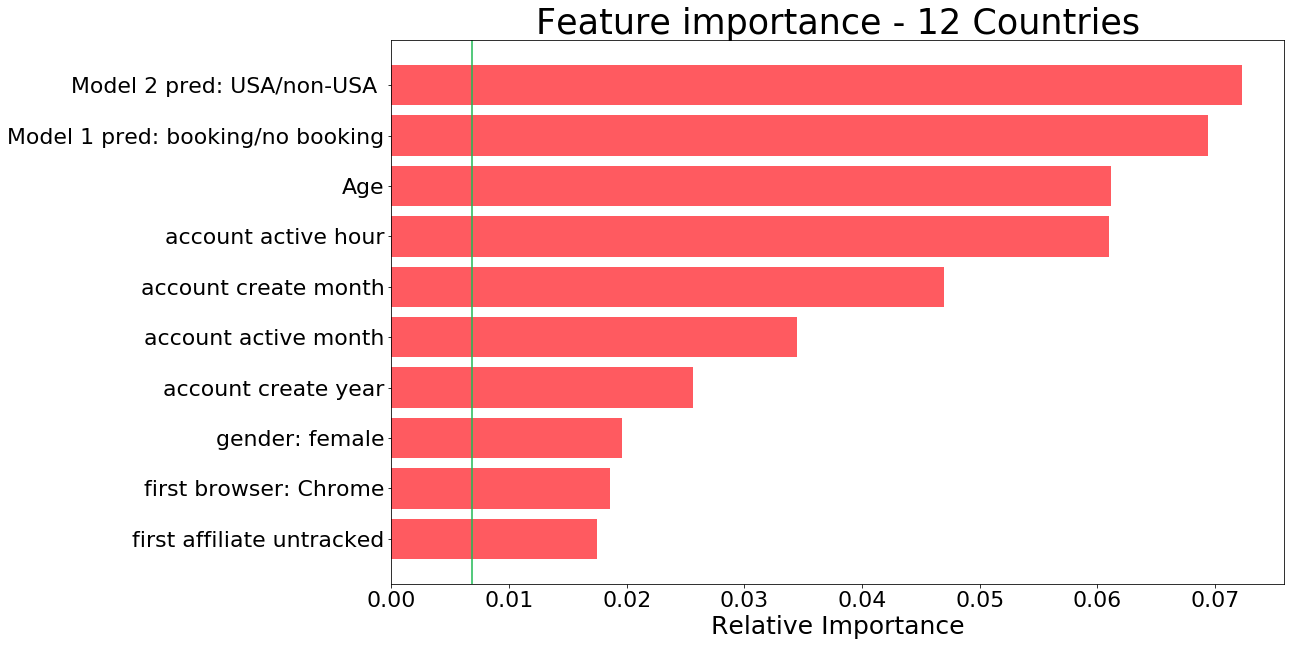

In [531]:
columns_name = (['Model 2 pred: USA/non-USA ', 
            'Model 1 pred: booking/no booking', 
            'Age', 
            'account active hour', 
            'account create month', 
            'account active month', 
            'account create year',
            'gender: female',
            'first browser: Chrome',
           'first affiliate untracked'])[::-1]
title = 'Feature importance - 12 Countries'
plot_importance(model3, X_train_2nd, title, columns_name);

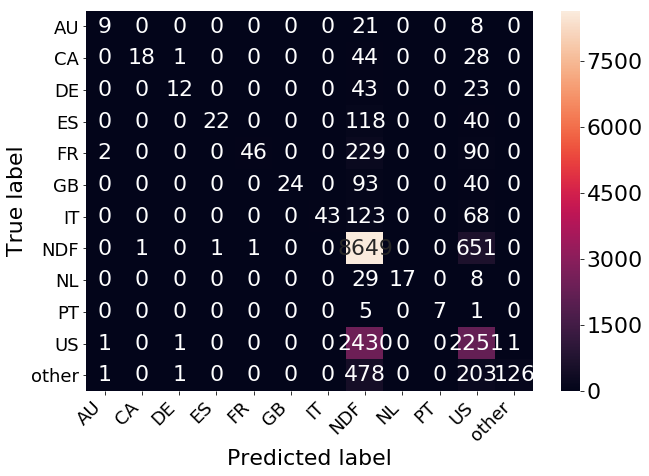

In [493]:
conf_mat = confusion_matrix(y_true=y_user_train, y_pred=y_train_down_pred3)
cm = print_confusion_matrix(conf_mat, sorted(y_user_train['country_destination'].unique().tolist()))

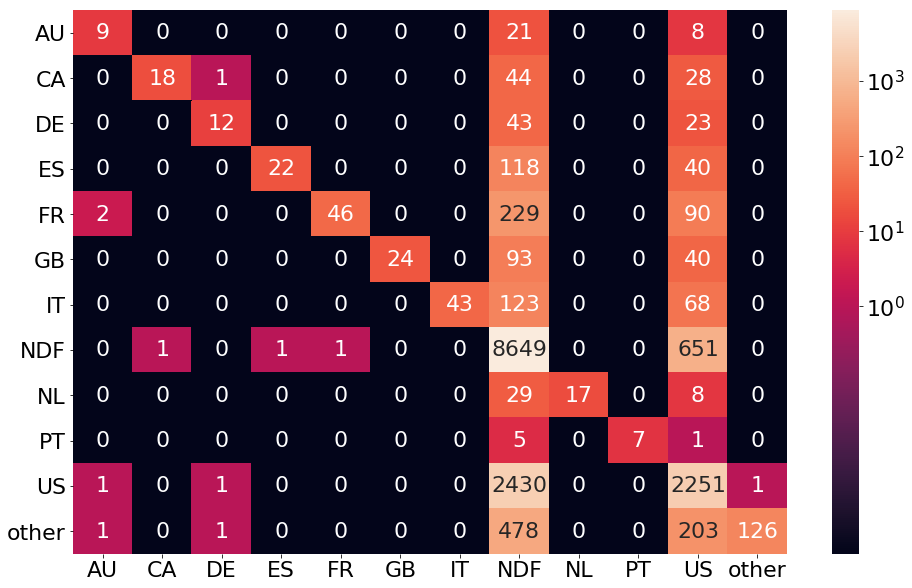

In [494]:
from matplotlib.colors import LogNorm
log_norm = LogNorm(vmin=0, vmax=conf_mat.max().max())

df_heatmap = pd.DataFrame(conf_mat + 0.0005, columns = sorted(y_user_train['country_destination'].unique().tolist()),
                          index=sorted(y_user_train['country_destination'].unique().tolist()))
sns.heatmap(df_heatmap, annot=True, norm=log_norm, cbar_kws={"ticks":[1,10,1e2,1e3,1e4,1e5]}, fmt='.0f')

In [614]:
def get_score(pred, real):

    cols = pred.columns
    ref = np.argsort(pred, axis=1)
    result = []
    match_table = []
    score = 0
    for row in range(pred.shape[0]):
        final = [cols[i] for i in ref.iloc[row,:]][-1:-6:-1]
        result.append(final)
        match = [int(x == real.iloc[row,0]) for x in final]
        match_table.append(match)
        sum=0
        for i in range(5):
            sum += (2**match[i]-1)/np.log2(i+1+1)
        # print ("real:", real.iloc[row,0], "predicted:", final, "score:", sum  )
        score += sum
        
    return result, score/len(pred), match_table

In [495]:
pred = pd.DataFrame(y_train_down_pred3_soft, columns=sorted(y_user_train['country_destination'].unique().tolist()))
train_result, train_score = get_score(pred, y_user_train)

In [496]:
print (train_score)

0.8732540237092531


## Check test performance

In [497]:
X_user_test, _ = impute_age(X_user_test, train_age_mode)
X_user_test, _ = custom_dummify(X_user_test, 0.005, user_train_cols)

/anaconda3/envs/Python36/lib/python3.6/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/anaconda3/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/envs/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """

In [498]:
index = (X_user_test.columns != X_user_train.columns)
X_user_train.columns[index]

Index([], dtype='object')

In [499]:
session_test, _ = impute_mode(session_test, 'action', 'action_type', action_type_mode)
session_test, _ = impute_mode(session_test, 'action', 'action_detail', action_detail_mode)
session_test, _ = impute_mode(session_test, 'action', 'secs_elapsed', action_secs_mode)
session_test.fillna("catch-all", inplace=True)
session_stats_test = get_session_cat_stats(X_user_test, session_test)

In [500]:
X_user_test_1 = deepcopy(X_user_test)
X_user_test_1 = X_user_test_1.merge(session_stats_test, how='left', left_index=True, right_index=True)
X_user_test_1 = get_session_continous_stats(X_user_test_1, session_test)
X_user_test_1.fillna(0.0, inplace=True)

/anaconda3/envs/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'user_id' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


In [501]:
index = (X_user_test_1.columns != X_user_train_1.columns)
X_user_test_1.columns[index]
X_user_train_1.columns[index]

Index([], dtype='object')

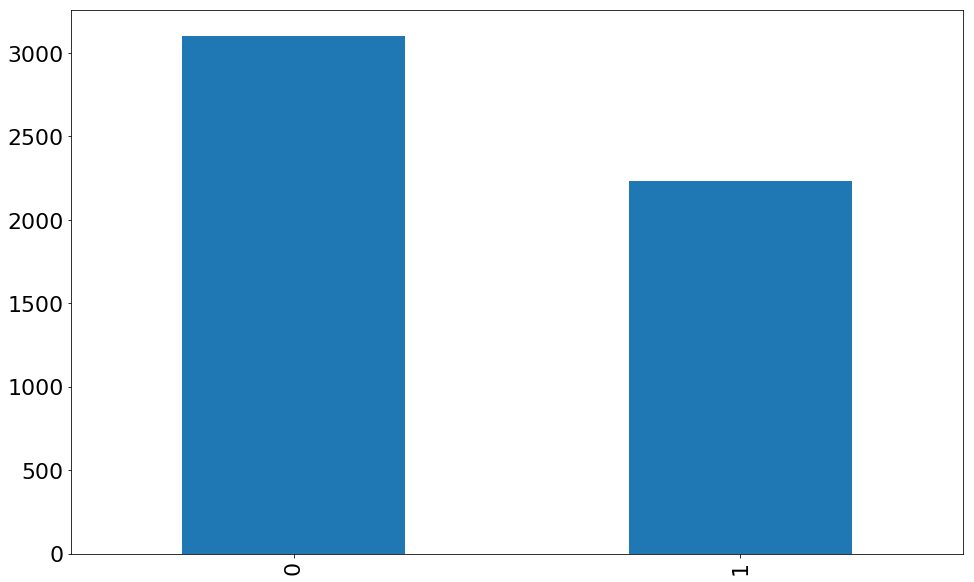

In [503]:
y_bin_test = deepcopy(y_user_test)
y_bin_test['booking'] = 1 - (y_bin_test['country_destination'] == 'NDF').astype('int')
y_bin_test.drop(['country_destination'], axis=1, inplace=True)
y_test=y_bin_test
y_test['booking'].value_counts().plot('bar')

In [504]:
X_test_imputed_scaled = ssX.transform(X_user_test_1)

In [517]:
y_test_pred = model1.predict(X_test_imputed_scaled)
y_test_pred_soft = model1.predict_proba(X_test_imputed_scaled)
model1.score(X_test_imputed_scaled, y_test)

/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7159452876147648

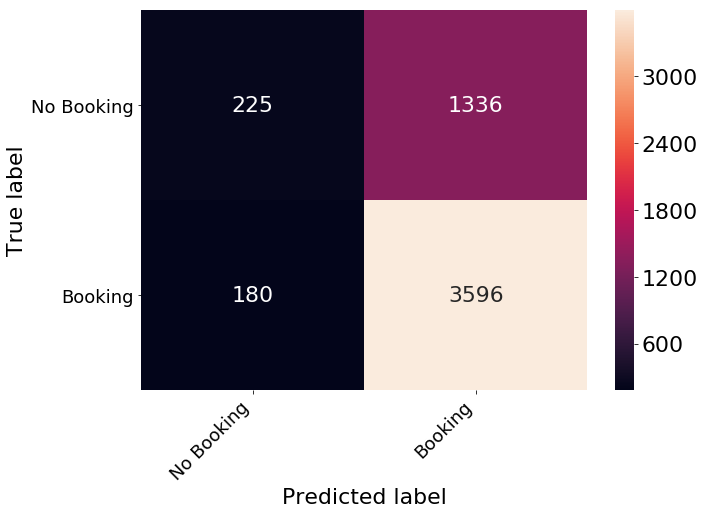

In [518]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
cm = print_confusion_matrix(conf_mat, ['No Booking', 'Booking'])

In [528]:
y_us_test = deepcopy(y_user_test)
y_us_test['booking'] = 1 - (y_us_test['country_destination'] == 'US').astype('int')
y_us_test.drop(['country_destination'], axis=1, inplace=True)
y_test=y_us_test

In [532]:
y_test_pred2 = model2.predict(X_test_imputed_scaled)
y_test_pred2_soft = model2.predict_proba(X_test_imputed_scaled)
model2.score(X_test_imputed_scaled, y_test)

/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7178189994378864

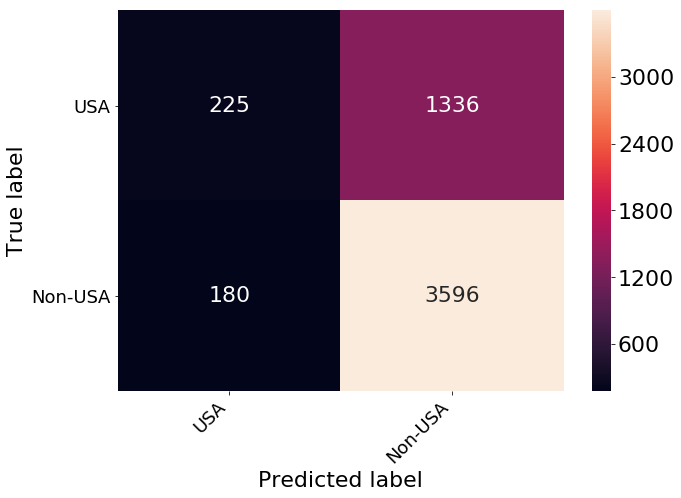

In [534]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
cm = print_confusion_matrix(conf_mat, ['USA', 'Non-USA'])

In [535]:
X_test_2nd = np.append(X_test_imputed_scaled, y_test_pred_soft[:,0].reshape(-1,1), axis=1)
X_test_2nd = np.append(X_test_2nd, y_test_pred2_soft[:,0].reshape(-1,1), axis=1)
#X_test_2nd = np.append(X_test_imputed_scaled, y_test_pred.reshape(-1,1), axis=1)
#X_test_2nd = np.append(X_test_2nd, y_test_pred2.reshape(-1,1), axis=1)

In [536]:
print ('Accuracy score is', model3.score(X_test_2nd, y_user_test))
y_test_pred3 = model3.predict(X_test_2nd)
y_test_pred3_soft = model3.predict_proba(X_test_2nd)

/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy score is 0.6301292861157954


/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


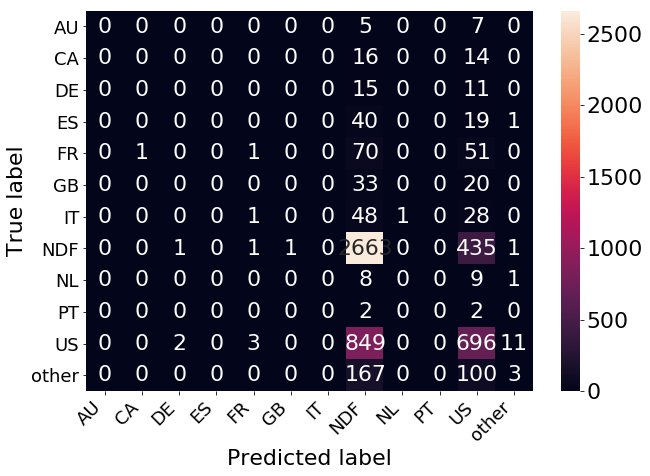

In [537]:
conf_mat = confusion_matrix(y_true=y_user_test, y_pred=y_test_pred3)
cm = print_confusion_matrix(conf_mat, sorted(y_user_test['country_destination'].unique().tolist()))



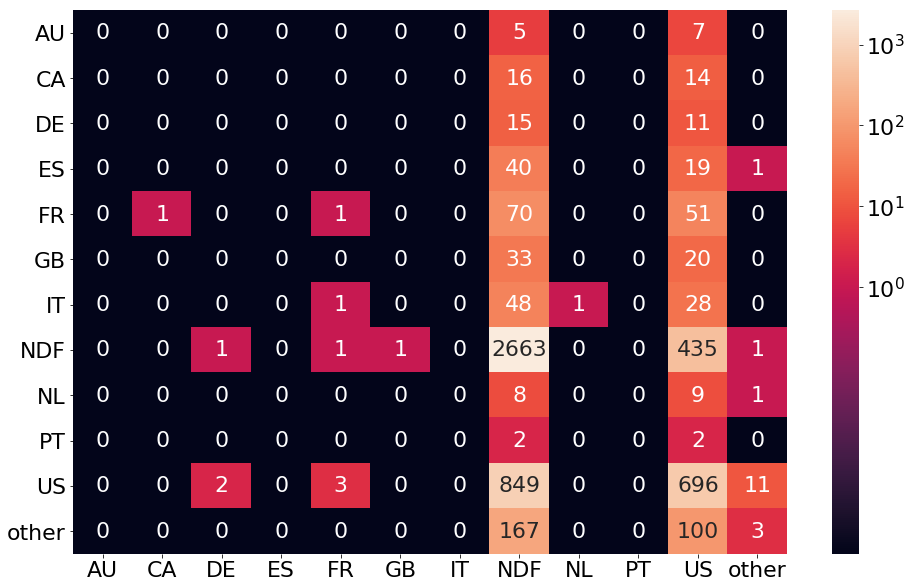

In [538]:
from matplotlib.colors import LogNorm
log_norm = LogNorm(vmin=0, vmax=conf_mat.max().max())

df_heatmap = pd.DataFrame(conf_mat + 0.0005, columns = sorted(y_user_train['country_destination'].unique().tolist()),
                          index=sorted(y_user_train['country_destination'].unique().tolist()))
sns.heatmap(df_heatmap, annot=True, norm=log_norm, cbar_kws={"ticks":[1,10,1e2,1e3,1e4,1e5]}, fmt='.0f')

In [615]:
pred_test = pd.DataFrame(y_test_pred3_soft, columns=sorted(y_user_train['country_destination'].unique().tolist()))
result, score_test, match_table = get_score(pred_test, y_user_test)

In [676]:
score_test

0.8157065155912052

In [616]:
match = pd.DataFrame(np.concatenate((match_table, np.array(y_user_test)), axis=1), columns=['1st match', '2nd match', '3rd match', '4th match', '5th match', 'True Label'])

In [622]:
match_table

[[1, 0, 0, 0, 0],
 [0, 0, 1, 0, 0],
 [1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [0, 0, 1, 0, 0],
 [1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [0, 0, 0, 1, 0],
 [0, 0, 1, 0, 0],
 [0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [0, 0, 0, 1, 0],
 [0, 1, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [0, 0, 0, 1, 0],
 [1, 0, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [0, 0, 1,

In [623]:
match_sum = np.array(match.groupby('True Label').apply(lambda x:np.sum(x)[:-1]))
match_sum.sum(axis=1)

array([   0,    3,    4,   14,   88,   18,   33, 3102,    1,    0, 1553,
        251])

In [631]:
true_count = y_user_test['country_destination'].value_counts().reset_index().sort_values('index')['country_destination']
no_match = true_count - np.sum(match_sum, axis=1)
no_match.shape

(12,)

In [630]:
match_sum.shape

(12, 5)

In [639]:
match_all = np.concatenate((match_sum, no_match.reshape(-1,1)), axis=1)
match_perc = match_all/(np.sum(match_all, axis=1).reshape(-1,1))

/anaconda3/envs/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


In [640]:
match_perc

array([[   0.000,    0.000,    0.000,    0.000,    0.000,    1.000],
       [   0.000,    0.000,    0.033,    0.033,    0.033,    0.900],
       [   0.000,    0.000,    0.038,    0.077,    0.038,    0.846],
       [   0.000,    0.000,    0.033,    0.083,    0.117,    0.767],
       [   0.008,    0.041,    0.220,    0.187,    0.260,    0.285],
       [   0.000,    0.019,    0.075,    0.113,    0.132,    0.660],
       [   0.000,    0.013,    0.077,    0.192,    0.141,    0.577],
       [   0.858,    0.133,    0.008,    0.001,    0.000,    0.000],
       [   0.000,    0.000,    0.000,    0.000,    0.056,    0.944],
       [   0.000,    0.000,    0.000,    0.000,    0.000,    1.000],
       [   0.446,    0.496,    0.031,    0.014,    0.007,    0.005],
       [   0.011,    0.070,    0.522,    0.252,    0.074,    0.070]])

In [ ]:
In [13]: N, K = doctopic.shape  # N documents, K topics

In [14]: ind = np.arange(N)  # the x-axis locations for the novels

In [15]: width = 0.5  # the width of the bars

In [16]: plots = []

In [17]: height_cumulative = np.zeros(N)

In [18]: for k in range(K):
   ....:     color = plt.cm.coolwarm(k/K, 1)
   ....:     if k == 0:
   ....:         p = plt.bar(ind, doctopic[:, k], width, color=color)
   ....:     else:
   ....:         p = plt.bar(ind, doctopic[:, k], width, bottom=height_cumulative, color=color)
   ....:     height_cumulative += doctopic[:, k]
   ....:     plots.append(p)
   ....: 
In [19]: plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
Out[19]: (0, 1)

In [20]: plt.ylabel('Topics')
Out[20]: <matplotlib.text.Text at 0x2b10d01bbc88>

In [21]: plt.title('Topics in novels')
Out[21]: <matplotlib.text.Text at 0x2b10cffeea90>

In [22]: plt.xticks(ind+width/2, docnames)
Out[22]: 

In [ ]:
In [20]: plt.ylabel('Topics')
Out[20]: <matplotlib.text.Text at 0x2b10d01bbc88>

In [21]: plt.title('Topics in novels')
Out[21]: <matplotlib.text.Text at 0x2b10cffeea90>

In [22]: plt.xticks(ind+width/2, docnames)
Out[22]: 
([<matplotlib.axis.XTick at 0x2b10cffc4518>,
  <matplotlib.axis.XTick at 0x2b10cffc4780>,
  <matplotlib.axis.XTick at 0x2b10d01bb588>,
  <matplotlib.axis.XTick at 0x2b10cfedc908>,
  <matplotlib.axis.XTick at 0x2b10d02120b8>,
  <matplotlib.axis.XTick at 0x2b10c1716710>],
 <a list of 6 Text xticklabel objects>)

In [23]: plt.yticks(np.arange(0, 1, 10))
Out[23]: 
([<matplotlib.axis.YTick at 0x2b10d01c9588>],
 <a list of 1 Text yticklabel objects>)

In [24]: topic_labels = ['Topic #{}'.format(k) for k in range(K)]

# see http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.legend for details
# on making a legend in matplotlib
In [25]: plt.legend([p[0] for p in plots], topic_labels)
Out[25]: <matplotlib.legend.Legend at 0x2b10cfec9f60>

In [26]: plt.show()

ValueError: Invalid RGBA argument: 'o'

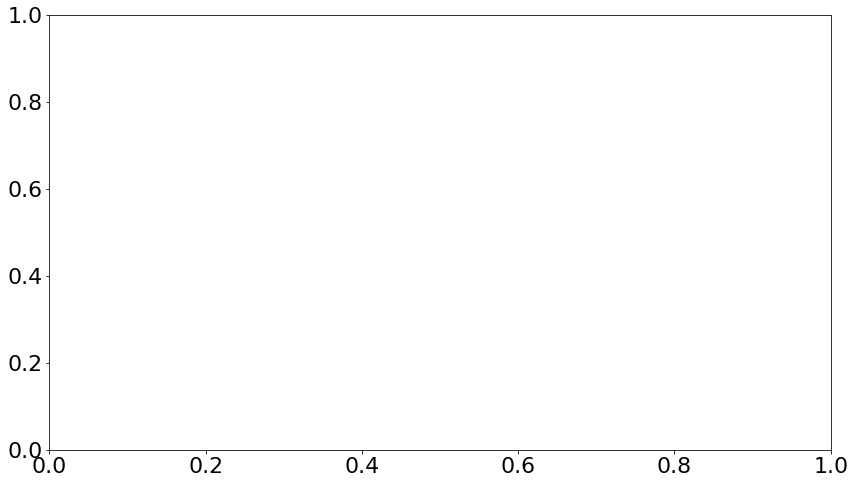

In [678]:
N, K = match_perc.shape
ind = np.arange(N)
width = 0.5
plots = []
height_cumulative = np.zeros(N)
for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, match_perc[:, k], width, color=color)
    else:
        p = plt.bar(ind, match_perc[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += match_perc[:, k]
    plots.append(p)
plt.ylim((0, 1))
plt.ylabel('Match percentage', fontsize=25)
plt.title('Prediction-true label match percentage', fontsize=35)
plt.xticks(ind, sorted(y_user_train['country_destination'].unique().tolist()));
match_type = ['1st match', '2nd match', '3rd match', '4th match', '5th match', 'No match']
topic_labels = ['Topic #{}'.format(match_type[k]) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left')

/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. R

/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1

/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1

/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1

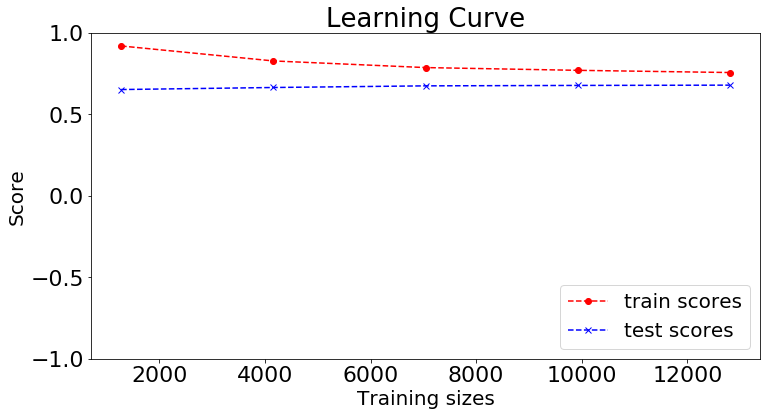

In [667]:
from sklearn.model_selection import learning_curve
# Make a model, say quadratic

train_sizes, train_scores, test_scores = learning_curve(model3, np.array(X_train_2nd), y_user_train, cv=5)
ave_train_scores = train_scores.mean(axis=1)
ave_test_scores = test_scores.mean(axis=1)

learn_df  = pd.DataFrame({
    'train_size': train_sizes,
    'train_score': ave_train_scores,
    'test_score': ave_test_scores
})

plot_lm_0 = plt.figure(1)
plot_lm_0.set_figheight(6)
plot_lm_0.set_figwidth(12)
plt.plot(learn_df['train_size'], learn_df['train_score'], 'r--o', label='train scores')
plt.plot(learn_df['train_size'], learn_df['test_score'], 'b--x', label='test scores')
plt.legend(loc='lower right', fontsize=20)
plt.xlabel('Training sizes', fontsize=20)
plt.ylabel('Score', fontsize=20)
plt.title('Learning Curve', fontsize=26)
plt.ylim(-1,1)
plt.savefig('learning_curve.png')

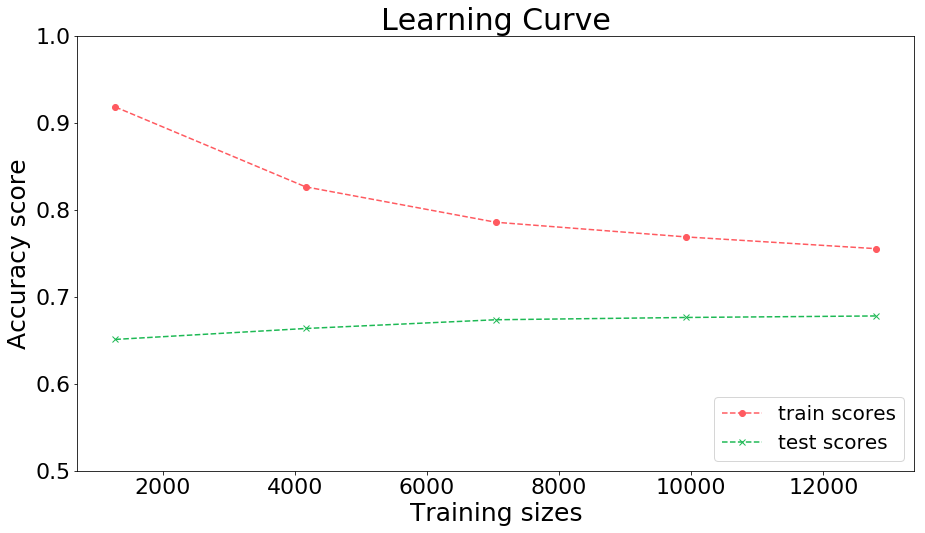

In [675]:
plot_lm_0 = plt.figure(1)
plot_lm_0.set_figheight(8)
plot_lm_0.set_figwidth(15)
plt.plot(learn_df['train_size'], learn_df['train_score'], '--o', color='#FF5A60', label='train scores')
plt.plot(learn_df['train_size'], learn_df['test_score'], '--x', color='#1DB954', label='test scores')
plt.legend(loc='lower right', fontsize=20)
plt.xlabel('Training sizes', fontsize=25)
plt.ylabel('Accuracy score', fontsize=25)
plt.title('Learning Curve', fontsize=30)
plt.ylim(0.5,1)
plt.savefig('learning_curve.png')